In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

train_df = pd.read_csv('/content/drive/MyDrive/train_df.csv')

Mounted at /content/drive


In [ ]:
# import zipfile
# import pandas as pd


# # Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

# # Path to the zip file on Google Drive
# zip_file = '/content/drive/MyDrive/sentence_level_df.zip'

# # Unzip the file
# with zipfile.ZipFile(zip_file, 'r') as zipf:
#     zipf.extractall()

# # Path to the extracted csv file
# csv_file = 'sentence_level_df.csv'

# # Read the csv file into a DataFrame
# import pandas as pd
# sentence_level_df = pd.read_csv(csv_file)

# # Now you can use the sentence_level_df DataFrame
# print(sentence_level_df.head())

In [ ]:
from google.colab import drive
import pandas as pd

merged = pd.read_csv('/content/drive/MyDrive/df_filtered.csv')

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 100.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.2 MB/s eta 0:00:00


**BERT base**

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf

# Here I'm using placeholder column names. Replace 'sentences_column_name'
# and 'binary_labels_column_name' with your actual column names.
sentences = train_df['detokenized'].values
labels = train_df['binary_values'].values

# Filter out any sentences that are NaN from both sentences and labels
valid_indexes = pd.notnull(sentences)
sentences = sentences[valid_indexes]
labels = labels[valid_indexes]

# Set the maximum sequence length
MAX_LEN = 512

# Use the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize the sentences
input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences]

import numpy as np

input_ids = np.array(input_ids)

# Convert the list of 0s and 1s into a numpy array
labels = np.array(labels)

# Use train_test_split to split our data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2020, test_size=0.1)

# Convert splits to tensors
train_inputs = tf.constant(train_inputs)
validation_inputs = tf.constant(validation_inputs)
train_labels = tf.constant(train_labels)
validation_labels = tf.constant(validation_labels)

# Load the pretrained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2
)

# Optimizer, loss and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Training
history = model.fit(
    train_inputs, train_labels,
    validation_data=(validation_inputs, validation_labels),
    batch_size=32,
    epochs=20
)

# Save the model for future use
model.save_pretrained('./bert_uncased/')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
69/69 [==============================] - 86s 527ms/step - loss: 0.6471 - accuracy: 0.6098 - val_loss: 0.6269 - val_accuracy: 0.6926
Epoch 2/20
69/69 [==============================] - 33s 472ms/step - loss: 0.3830 - accuracy: 0.8291 - val_loss: 0.3443 - val_accuracy: 0.8566
Epoch 3/20
69/69 [==============================] - 32s 461ms/step - loss: 0.2300 - accuracy: 0.9166 - val_loss: 0.3272 - val_accuracy: 0.8566
Epoch 4/20
69/69 [==============================] - 31s 450ms/step - loss: 0.1523 - accuracy: 0.9494 - val_loss: 0.3939 - val_accuracy: 0.8770
Epoch 5/20
69/69 [==============================] - 31s 453ms/step - loss: 0.1177 - accuracy: 0.9654 - val_loss: 0.3726 - val_accuracy: 0.8689
Epoch 6/20
69/69 [==============================] - 31s 449ms/step - loss: 0.1007 - accuracy: 0.9690 - val_loss: 0.3779 - val_accuracy: 0.8934
Epoch 7/20
69/69 [==============================] - 31s 445ms/step - loss: 0.0781 - accuracy: 0.9758 - val_loss: 0.3916 - val_accuracy: 0.8975

8/8 [==============================] - 4s 138ms/step
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       116
           1       0.93      0.84      0.88       128

    accuracy                           0.88       244
   macro avg       0.88      0.88      0.88       244
weighted avg       0.89      0.88      0.88       244

F1-Score: 0.8806584362139918
Precision: 0.9304347826086956
Recall: 0.8359375
AUROC: 0.9289466594827587


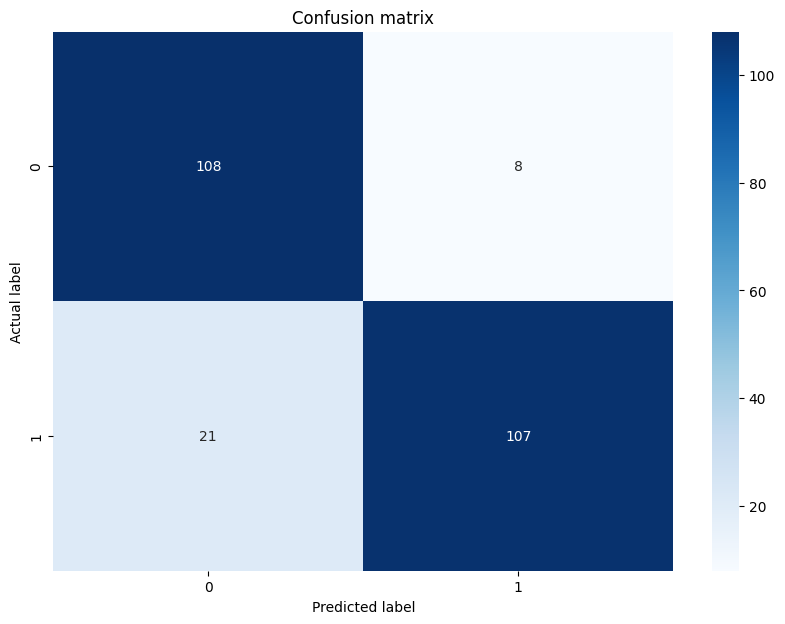

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

# Make predictions on the validation data
predictions = model.predict(validation_inputs)[0]  # Access the predictions

# The predictions are probabilities, so we take the label with the highest probability
predicted_labels = np.argmax(predictions, axis=1)

# Print a classification report
print(classification_report(validation_labels, predicted_labels))

# Calculate additional evaluation metrics
f1 = f1_score(validation_labels, predicted_labels)
precision = precision_score(validation_labels, predicted_labels)
recall = recall_score(validation_labels, predicted_labels)
auroc = roc_auc_score(validation_labels, predictions[:, 1])  # Assuming binary classification, use the probabilities of the positive class

# Print the additional metrics
print("F1-Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUROC:", auroc)

# Print the confusion matrix
cm = confusion_matrix(validation_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


203/203 [==============================] - 29s 143ms/step
              precision    recall  f1-score   support

           0       0.61      0.99      0.76      1077
           1       1.00      0.88      0.93      5402

    accuracy                           0.90      6479
   macro avg       0.81      0.93      0.85      6479
weighted avg       0.93      0.90      0.90      6479

F1-Score: 0.9329652996845426
Precision: 0.9978911851539435
Recall: 0.8759718622732321
AUROC: 0.9642947503538185


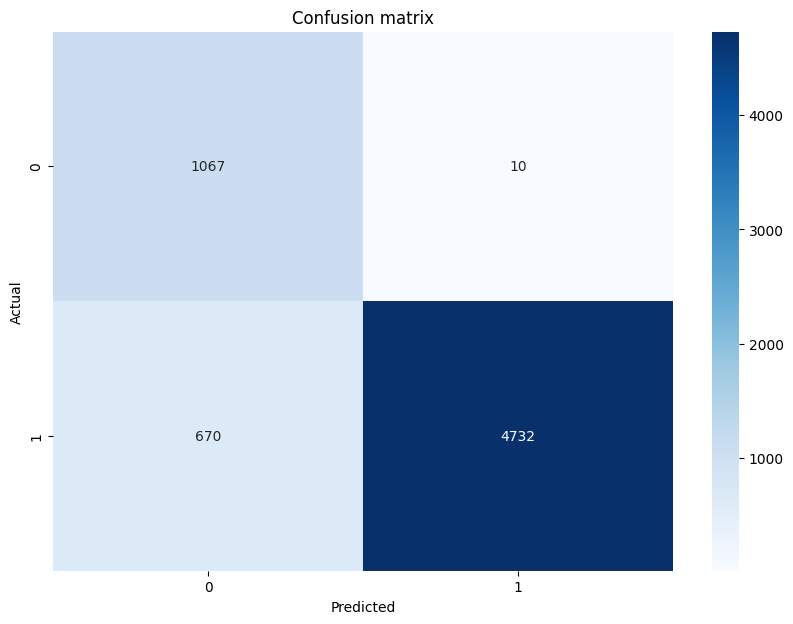

Test Loss: 0.6896893978118896
Test Accuracy: 0.8950455188751221


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Extract sentences and labels from the new dataframe
sentences_test = merged['lyrics_sentences'].values
labels_test = merged['smell_event'].values

# Filter out any sentences that are NaN from both sentences and labels
valid_indexes = pd.notnull(sentences_test)
sentences_test = sentences_test[valid_indexes]
labels_test = labels_test[valid_indexes]

# Tokenize the sentences
input_ids_test = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences_test]

# Convert lists to numpy arrays
input_ids_test = np.array(input_ids_test)
labels_test = np.array(labels_test)

# Convert arrays to tensors
test_inputs = tf.constant(input_ids_test)
test_labels = tf.constant(labels_test)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_inputs, test_labels, verbose=1)

# Predict the labels for the test set
predictions = model.predict(test_inputs)[0]  # Access the predictions
predicted_labels = np.argmax(predictions, axis=1)

# Print a classification report
print(classification_report(test_labels, predicted_labels))

# Calculate additional evaluation metrics
f1 = f1_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
auroc = roc_auc_score(test_labels, predictions[:, 1])  # Assuming binary classification, use the probabilities of the positive class

# Print the additional metrics
print("F1-Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUROC:", auroc)

# Print the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


**BERT large**

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Here I'm using placeholder column names. Replace 'sentences_column_name'
# and 'binary_labels_column_name' with your actual column names.
sentences = train_df['detokenized'].values
labels = train_df['binary_values'].values

# Filter out any sentences that are NaN from both sentences and labels
valid_indexes = pd.notnull(sentences)
sentences = sentences[valid_indexes]
labels = labels[valid_indexes]

# Set the maximum sequence length
MAX_LEN = 256

# Use the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)

# Tokenize the sentences
input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences]

import numpy as np

input_ids = np.array(input_ids)

# Convert the list of 0s and 1s into a numpy array
labels = np.array(labels)

# Use train_test_split to split our data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2020, test_size=0.1)

# Convert splits to tensors
train_inputs = tf.constant(train_inputs)
validation_inputs = tf.constant(validation_inputs)
train_labels = tf.constant(train_labels)
validation_labels = tf.constant(validation_labels)

# Load the pretrained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained(
    "bert-large-uncased",
    num_labels = 2
)

# Optimizer, loss and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)  # Reduced learning rate
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Training
history = model.fit(
    train_inputs, train_labels,
    validation_data=(validation_inputs, validation_labels),
    batch_size=32,  # Increased batch size
    epochs=20  # Reduced number of epochs
)

# Save the model for future use
model.save_pretrained('./bert_large_uncased/')

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
69/69 [==============================] - 148s 611ms/step - loss: 0.6328 - accuracy: 0.6249 - val_loss: 0.6496 - val_accuracy: 0.6598
Epoch 2/20
69/69 [==============================] - 35s 509ms/step - loss: 0.6474 - accuracy: 0.6171 - val_loss: 0.6797 - val_accuracy: 0.6025
Epoch 3/20
69/69 [==============================] - 32s 466ms/step - loss: 0.6054 - accuracy: 0.6531 - val_loss: 0.6422 - val_accuracy: 0.6967
Epoch 4/20
69/69 [==============================] - 33s 471ms/step - loss: 0.4840 - accuracy: 0.7593 - val_loss: 0.3669 - val_accuracy: 0.8238
Epoch 5/20
69/69 [==============================] - 32s 457ms/step - loss: 0.3153 - accuracy: 0.8792 - val_loss: 0.4079 - val_accuracy: 0.8443
Epoch 6/20
69/69 [==============================] - 31s 448ms/step - loss: 0.2728 - accuracy: 0.9020 - val_loss: 0.3040 - val_accuracy: 0.8811
Epoch 7/20
69/69 [==============================] - 31s 446ms/step - loss: 0.2192 - accuracy: 0.9243 - val_loss: 0.3227 - val_accuracy: 0.877

8/8 [==============================] - 7s 131ms/step
              precision    recall  f1-score   support

           0       0.85      0.97      0.91       116
           1       0.96      0.85      0.90       128

    accuracy                           0.91       244
   macro avg       0.91      0.91      0.91       244
weighted avg       0.91      0.91      0.91       244

F1-Score: 0.904564315352697
Precision: 0.9646017699115044
Recall: 0.8515625
AUROC: 0.9447063577586207


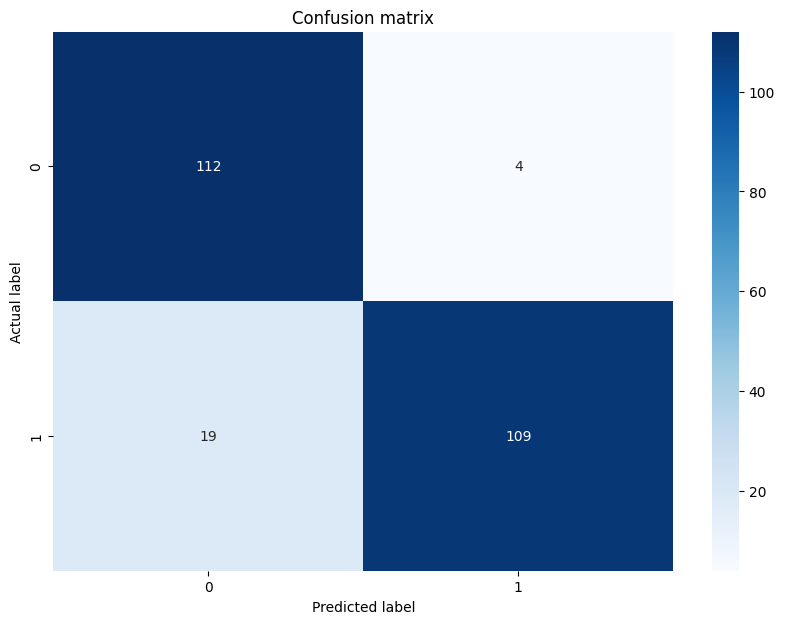

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

# Make predictions on the validation data
predictions = model.predict(validation_inputs)[0]  # Access the predictions

# The predictions are probabilities, so we take the label with the highest probability
predicted_labels = np.argmax(predictions, axis=1)

# Print a classification report
print(classification_report(validation_labels, predicted_labels))

# Calculate additional evaluation metrics
f1 = f1_score(validation_labels, predicted_labels)
precision = precision_score(validation_labels, predicted_labels)
recall = recall_score(validation_labels, predicted_labels)
auroc = roc_auc_score(validation_labels, predictions[:, 1])  # Assuming binary classification, use the probabilities of the positive class

# Print the additional metrics
print("F1-Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUROC:", auroc)

# Print the confusion matrix
cm = confusion_matrix(validation_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

203/203 [==============================] - 28s 136ms/step
              precision    recall  f1-score   support

           0       0.63      0.99      0.77      1077
           1       1.00      0.88      0.94      5402

    accuracy                           0.90      6479
   macro avg       0.81      0.94      0.85      6479
weighted avg       0.94      0.90      0.91      6479

F1-Score: 0.9368307299341783
Precision: 0.9981159723675948
Recall: 0.8826360607182525
AUROC: 0.9648371231536036


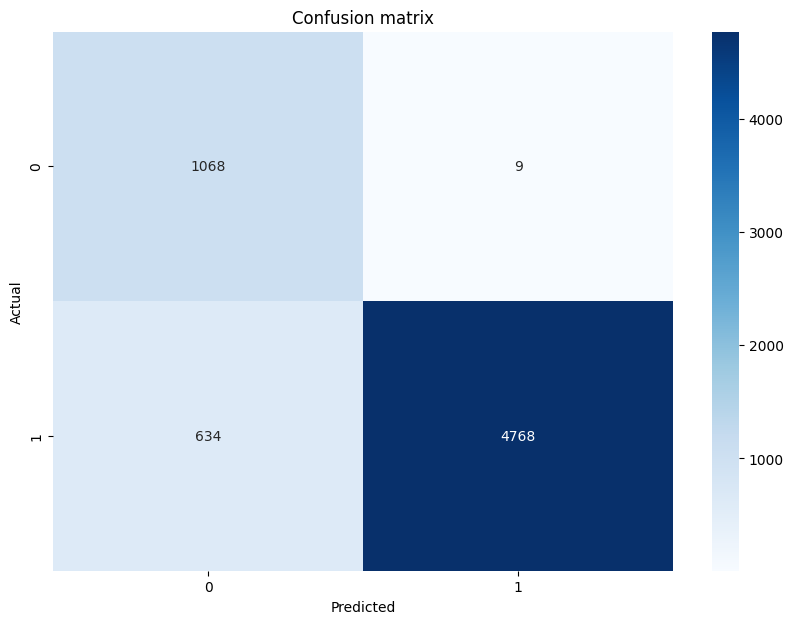

Test Loss: 0.6380176544189453
Test Accuracy: 0.900756299495697


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Extract sentences and labels from the new dataframe
sentences_test = merged['lyrics_sentences'].values
labels_test = merged['smell_event'].values

# Filter out any sentences that are NaN from both sentences and labels
valid_indexes = pd.notnull(sentences_test)
sentences_test = sentences_test[valid_indexes]
labels_test = labels_test[valid_indexes]

# Tokenize the sentences
input_ids_test = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences_test]

# Convert lists to numpy arrays
input_ids_test = np.array(input_ids_test)
labels_test = np.array(labels_test)

# Convert arrays to tensors
test_inputs = tf.constant(input_ids_test)
test_labels = tf.constant(labels_test)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_inputs, test_labels, verbose=1)

# Predict the labels for the test set
predictions = model.predict(test_inputs)[0]  # Access the predictions
predicted_labels = np.argmax(predictions, axis=1)

# Print a classification report
print(classification_report(test_labels, predicted_labels))

# Calculate additional evaluation metrics
f1 = f1_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
auroc = roc_auc_score(test_labels, predictions[:, 1])  # Assuming binary classification, use the probabilities of the positive class

# Print the additional metrics
print("F1-Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUROC:", auroc)

# Print the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")


**RoBERTa base**

In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Here I'm using placeholder column names. Replace 'sentences_column_name'
# and 'binary_labels_column_name' with your actual column names.
sentences = train_df['detokenized'].values
labels = train_df['binary_values'].values

# Filter out any sentences that are NaN from both sentences and labels
valid_indexes = pd.notnull(sentences)
sentences = sentences[valid_indexes]
labels = labels[valid_indexes]

# Set the maximum sequence length
MAX_LEN = 512

# Use the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)

# Tokenize the sentences
input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences]

input_ids = np.array(input_ids)

# Convert the list of 0s and 1s into a numpy array
labels = np.array(labels)

# Use train_test_split to split our data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2020, test_size=0.1)

# Convert splits to tensors
train_inputs = tf.constant(train_inputs)
validation_inputs = tf.constant(validation_inputs)
train_labels = tf.constant(train_labels)
validation_labels = tf.constant(validation_labels)

# Load the pretrained RoBERTa model for sequence classification
model = TFRobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Optimizer, loss and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Training
history = model.fit(train_inputs, train_labels, validation_data=(validation_inputs, validation_labels), batch_size=32, epochs=20)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/20
69/69 [==============================] - 88s 591ms/step - loss: 0.6543 - accuracy: 0.5770 - val_loss: 0.6925 - val_accuracy: 0.4754
Epoch 2/20
69/69 [==============================] - 35s 501ms/step - loss: 0.6416 - accuracy: 0.5638 - val_loss: 0.6998 - val_accuracy: 0.6352
Epoch 3/20
69/69 [==============================] - 32s 466ms/step - loss: 0.6178 - accuracy: 0.6299 - val_loss: 0.7051 - val_accuracy: 0.5820
Epoch 4/20
69/69 [==============================] - 29s 424ms/step - loss: 0.6216 - accuracy: 0.6226 - val_loss: 0.7337 - val_accuracy: 0.6393
Epoch 5/20
69/69 [==============================] - 27s 384ms/step - loss: 0.6095 - accuracy: 0.6358 - val_loss: 0.7443 - val_accuracy: 0.6434
Epoch 6/20
69/69 [==============================] - 26s 374ms/step - loss: 0.6069 - accuracy: 0.6509 - val_loss: 0.6957 - val_accuracy: 0.6025
Epoch 7/20
69/69 [==============================] - 25s 368ms/step - loss: 0.5937 - accuracy: 0.6595 - val_loss: 0.6575 - val_accuracy: 0.6516

8/8 [==============================] - 4s 101ms/step
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       116
           1       0.92      0.78      0.84       128

    accuracy                           0.85       244
   macro avg       0.86      0.85      0.85       244
weighted avg       0.86      0.85      0.85       244

F1-Score: 0.8438818565400844
Precision: 0.9174311926605505
Recall: 0.78125
AUROC: 0.9006600215517242


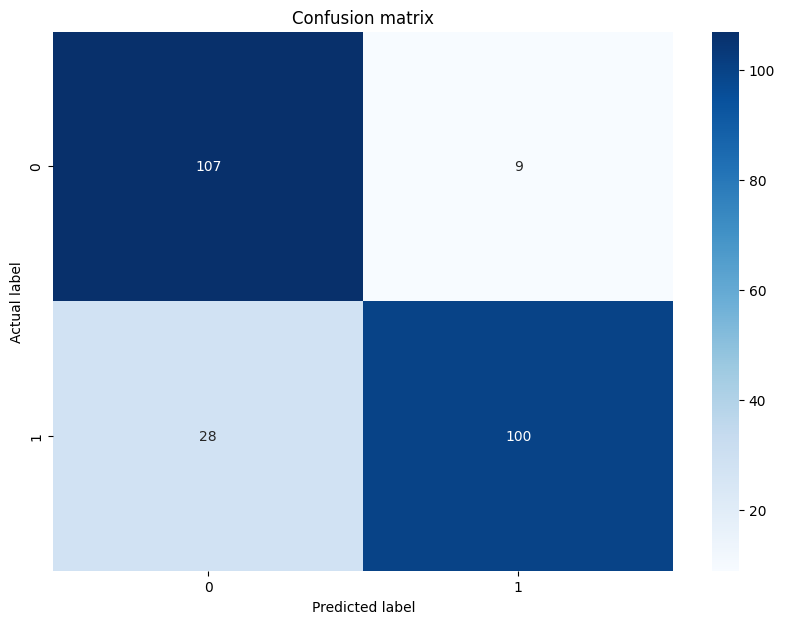

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

# Make predictions on the validation data
predictions = model.predict(validation_inputs)[0]  # Access the predictions

# The predictions are probabilities, so we take the label with the highest probability
predicted_labels = np.argmax(predictions, axis=1)

# Print a classification report
print(classification_report(validation_labels, predicted_labels))

# Calculate additional evaluation metrics
f1 = f1_score(validation_labels, predicted_labels)
precision = precision_score(validation_labels, predicted_labels)
recall = recall_score(validation_labels, predicted_labels)
auroc = roc_auc_score(validation_labels, predictions[:, 1])  # Assuming binary classification, use the probabilities of the positive class

# Print the additional metrics
print("F1-Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUROC:", auroc)

# Print the confusion matrix
cm = confusion_matrix(validation_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

203/203 [==============================] - 21s 104ms/step
              precision    recall  f1-score   support

           0       0.53      0.99      0.69      1077
           1       1.00      0.82      0.90      5402

    accuracy                           0.85      6479
   macro avg       0.76      0.91      0.79      6479
weighted avg       0.92      0.85      0.87      6479

F1-Score: 0.9011568906028007
Precision: 0.9973045822102425
Recall: 0.821917808219178
AUROC: 0.9393913221039559


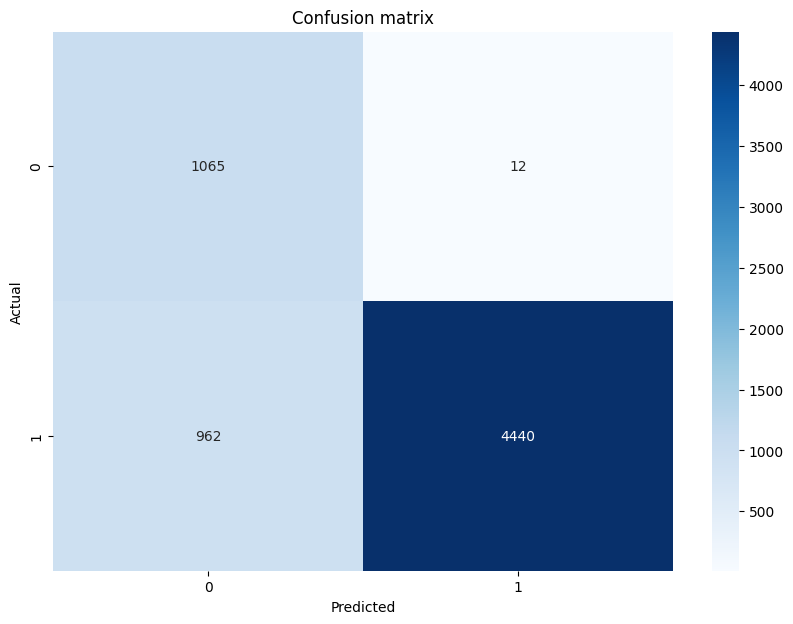

Test Loss: 0.7774093151092529
Test Accuracy: 0.8496681451797485


In [ ]:
# Extract sentences and labels from the new dataframe
sentences_test = merged['lyrics_sentences'].values
labels_test = merged['smell_event'].values

# Filter out any sentences that are NaN from both sentences and labels
valid_indexes = pd.notnull(sentences_test)
sentences_test = sentences_test[valid_indexes]
labels_test = labels_test[valid_indexes]

# Tokenize the sentences
input_ids_test = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences_test]

# Convert lists to numpy arrays
input_ids_test = np.array(input_ids_test)
labels_test = np.array(labels_test)

# Convert arrays to tensors
test_inputs = tf.constant(input_ids_test)
test_labels = tf.constant(labels_test)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_inputs, test_labels, verbose=1)

# Predict the labels for the test set
predictions = model.predict(test_inputs)[0]  # Access the predictions
predicted_labels = np.argmax(predictions, axis=1)

# Print a classification report
print(classification_report(test_labels, predicted_labels))

# Calculate additional evaluation metrics
f1 = f1_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
auroc = roc_auc_score(test_labels, predictions[:, 1])  # Assuming binary classification, use the probabilities of the positive class

# Print the additional metrics
print("F1-Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUROC:", auroc)

# Print the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

**RoBERTa large**

In [ ]:
from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Here I'm using placeholder column names. Replace 'sentences_column_name'
# and 'binary_labels_column_name' with your actual column names.
sentences = train_df['detokenized'].values
labels = train_df['binary_values'].values

# Filter out any sentences that are NaN from both sentences and labels
valid_indexes = pd.notnull(sentences)
sentences = sentences[valid_indexes]
labels = labels[valid_indexes]

# Set the maximum sequence length
MAX_LEN = 256

# Use the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-large', do_lower_case=True)

# Tokenize the sentences
input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences]

input_ids = np.array(input_ids)

# Convert the list of 0s and 1s into a numpy array
labels = np.array(labels)

# Use train_test_split to split our data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2020, test_size=0.1)

# Convert splits to tensors
train_inputs = tf.constant(train_inputs)
validation_inputs = tf.constant(validation_inputs)
train_labels = tf.constant(train_labels)
validation_labels = tf.constant(validation_labels)

# Load the pretrained RoBERTa model for sequence classification
model = TFRobertaForSequenceClassification.from_pretrained("roberta-large", num_labels=2)

# Optimizer, loss and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Training
history = model.fit(train_inputs, train_labels, validation_data=(validation_inputs, validation_labels), batch_size=32, epochs=20)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/20
69/69 [==============================] - 138s 639ms/step - loss: 0.6856 - accuracy: 0.5387 - val_loss: 0.7014 - val_accuracy: 0.4795
Epoch 2/20
69/69 [==============================] - 35s 505ms/step - loss: 0.6758 - accuracy: 0.5556 - val_loss: 0.6802 - val_accuracy: 0.5943
Epoch 3/20
69/69 [==============================] - 33s 484ms/step - loss: 0.6602 - accuracy: 0.5789 - val_loss: 0.7260 - val_accuracy: 0.6557
Epoch 4/20
69/69 [==============================] - 33s 475ms/step - loss: 0.5607 - accuracy: 0.6964 - val_loss: 0.4156 - val_accuracy: 0.8115
Epoch 5/20
69/69 [==============================] - 32s 460ms/step - loss: 0.3258 - accuracy: 0.8751 - val_loss: 0.3579 - val_accuracy: 0.8484
Epoch 6/20
69/69 [==============================] - 30s 440ms/step - loss: 0.2737 - accuracy: 0.9020 - val_loss: 0.3820 - val_accuracy: 0.8607
Epoch 7/20
69/69 [==============================] - 31s 446ms/step - loss: 0.2073 - accuracy: 0.9198 - val_loss: 0.4521 - val_accuracy: 0.873

8/8 [==============================] - 7s 132ms/step
              precision    recall  f1-score   support

           0       0.86      0.83      0.85       116
           1       0.85      0.88      0.87       128

    accuracy                           0.86       244
   macro avg       0.86      0.86      0.86       244
weighted avg       0.86      0.86      0.86       244

F1-Score: 0.8659003831417625
Precision: 0.849624060150376
Recall: 0.8828125
AUROC: 0.9390827047413792


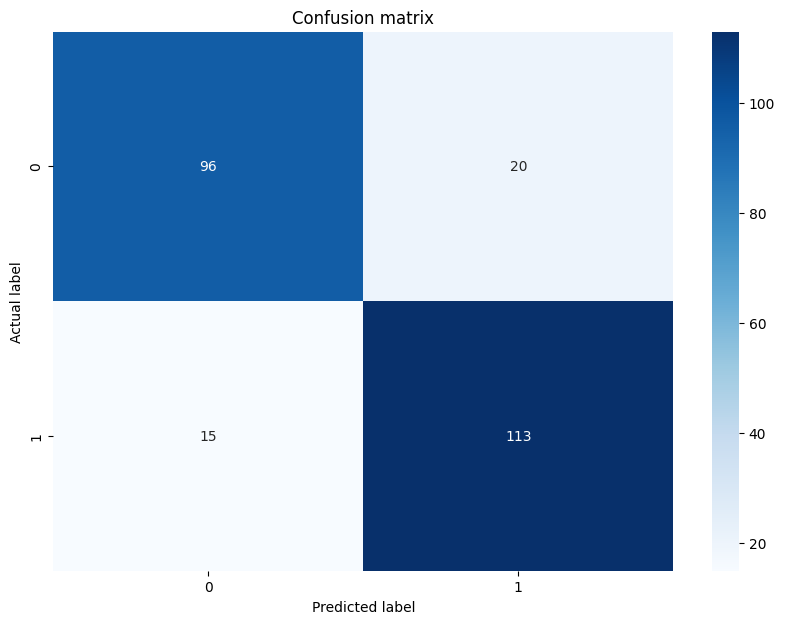

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score

# Make predictions on the validation data
predictions = model.predict(validation_inputs)[0]  # Access the predictions

# The predictions are probabilities, so we take the label with the highest probability
predicted_labels = np.argmax(predictions, axis=1)

# Print a classification report
print(classification_report(validation_labels, predicted_labels))

# Calculate additional evaluation metrics
f1 = f1_score(validation_labels, predicted_labels)
precision = precision_score(validation_labels, predicted_labels)
recall = recall_score(validation_labels, predicted_labels)
auroc = roc_auc_score(validation_labels, predictions[:, 1])  # Assuming binary classification, use the probabilities of the positive class

# Print the additional metrics
print("F1-Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUROC:", auroc)

# Print the confusion matrix
cm = confusion_matrix(validation_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

203/203 [==============================] - 28s 137ms/step
              precision    recall  f1-score   support

           0       0.68      0.92      0.78      1077
           1       0.98      0.91      0.95      5402

    accuracy                           0.91      6479
   macro avg       0.83      0.92      0.86      6479
weighted avg       0.93      0.91      0.92      6479

F1-Score: 0.9463976945244956
Precision: 0.9836261980830671
Recall: 0.911884487226953
AUROC: 0.9664490300198317


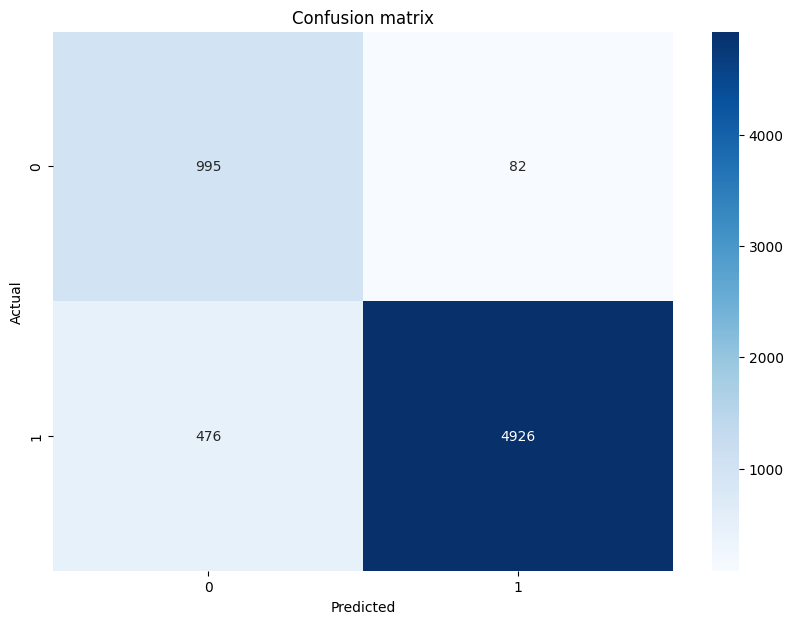

Test Loss: 0.2831104099750519
Test Accuracy: 0.9138755798339844


In [ ]:
# Extract sentences and labels from the new dataframe
sentences_test = merged['lyrics_sentences'].values
labels_test = merged['smell_event'].values

# Filter out any sentences that are NaN from both sentences and labels
valid_indexes = pd.notnull(sentences_test)
sentences_test = sentences_test[valid_indexes]
labels_test = labels_test[valid_indexes]

# Tokenize the sentences
input_ids_test = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences_test]

# Convert lists to numpy arrays
input_ids_test = np.array(input_ids_test)
labels_test = np.array(labels_test)

# Convert arrays to tensors
test_inputs = tf.constant(input_ids_test)
test_labels = tf.constant(labels_test)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_inputs, test_labels, verbose=1)

# Predict the labels for the test set
predictions = model.predict(test_inputs)[0]  # Access the predictions
predicted_labels = np.argmax(predictions, axis=1)

# Print a classification report
print(classification_report(test_labels, predicted_labels))

# Calculate additional evaluation metrics
f1 = f1_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
auroc = roc_auc_score(test_labels, predictions[:, 1])  # Assuming binary classification, use the probabilities of the positive class

# Print the additional metrics
print("F1-Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUROC:", auroc)

# Print the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")

## **MacBERTh**

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf

# Here I'm using placeholder column names. Replace 'sentences_column_name'
# and 'binary_labels_column_name' with your actual column names.
sentences = train_df['detokenized'].values
labels = train_df['binary_values'].values

# Filter out any sentences that are NaN from both sentences and labels
valid_indexes = pd.notnull(sentences)
sentences = sentences[valid_indexes]
labels = labels[valid_indexes]

# Set the maximum sequence length
MAX_LEN = 512

# Use the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('emanjavacas/MacBERTh', do_lower_case=True)

# Tokenize the sentences
input_ids = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences]

import numpy as np

input_ids = np.array(input_ids)

# Convert the list of 0s and 1s into a numpy array
labels = np.array(labels)

# Use train_test_split to split our data into train and validation sets
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2020, test_size=0.1)

# Convert splits to tensors
train_inputs = tf.constant(train_inputs)
validation_inputs = tf.constant(validation_inputs)
train_labels = tf.constant(train_labels)
validation_labels = tf.constant(validation_labels)

# Load the pretrained BERT model for sequence classification
model = TFBertForSequenceClassification.from_pretrained(
    "emanjavacas/MacBERTh",
    from_pt=True,
    num_labels = 2
)

# Optimizer, loss and metric
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

# Training
history = model.fit(
    train_inputs, train_labels,
    validation_data=(validation_inputs, validation_labels),
    batch_size=32,
    epochs=20
)

# Save the model for future use
model.save_pretrained('./MacBERTh/')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
69/69 [==============================] - 86s 550ms/step - loss: 0.6429 - accuracy: 0.5930 - val_loss: 0.7093 - val_accuracy: 0.6352
Epoch 2/20
69/69 [==============================] - 32s 459ms/step - loss: 0.6183 - accuracy: 0.6208 - val_loss: 0.6780 - val_accuracy: 0.5779
Epoch 3/20
69/69 [==============================] - 30s 433ms/step - loss: 0.4361 - accuracy: 0.7976 - val_loss: 0.4688 - val_accuracy: 0.8074
Epoch 4/20
69/69 [==============================] - 29s 422ms/step - loss: 0.2991 - accuracy: 0.8810 - val_loss: 0.3734 - val_accuracy: 0.8361
Epoch 5/20
69/69 [==============================] - 26s 380ms/step - loss: 0.2503 - accuracy: 0.9015 - val_loss: 0.4816 - val_accuracy: 0.8115
Epoch 6/20
69/69 [==============================] - 27s 398ms/step - loss: 0.2139 - accuracy: 0.9161 - val_loss: 0.5934 - val_accuracy: 0.8443
Epoch 7/20
69/69 [==============================] - 26s 374ms/step - loss: 0.1806 - accuracy: 0.9316 - val_loss: 0.4147 - val_accuracy: 0.8484

8/8 [==============================] - 4s 100ms/step
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       116
           1       0.89      0.85      0.87       128

    accuracy                           0.87       244
   macro avg       0.87      0.87      0.87       244
weighted avg       0.87      0.87      0.87       244

F1-Score: 0.8719999999999999
Precision: 0.8934426229508197
Recall: 0.8515625
AUROC: 0.9154094827586206


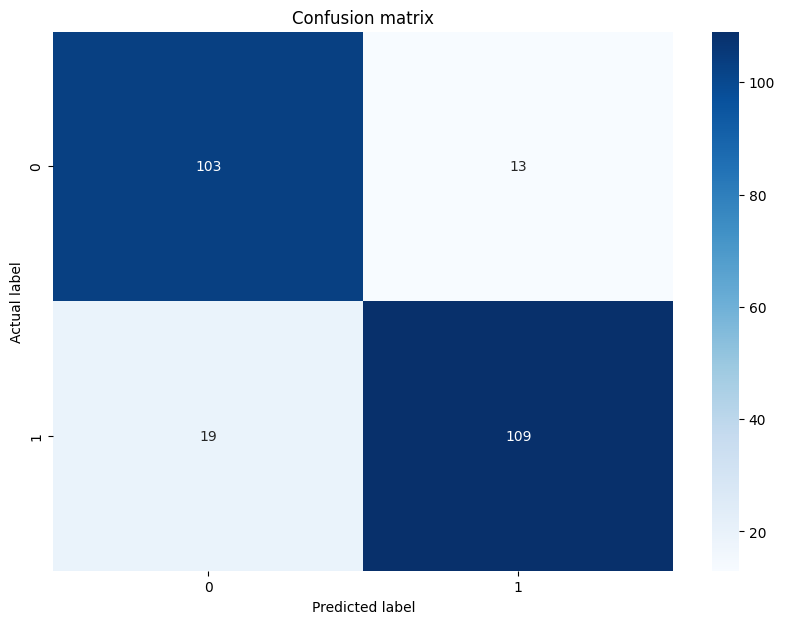

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming validation_inputs and validation_labels are already defined
predictions = model.predict(validation_inputs)[0]

# The predictions are probabilities, so we take the label with the highest probability
predicted_labels = np.argmax(predictions, axis=1)

# Print a classification report
print(classification_report(validation_labels, predicted_labels))

# Calculate additional evaluation metrics
f1 = f1_score(validation_labels, predicted_labels)
precision = precision_score(validation_labels, predicted_labels)
recall = recall_score(validation_labels, predicted_labels)
auroc = roc_auc_score(validation_labels, predictions[:, 1])  # Assuming binary classification, use the probabilities of the positive class

# Print the additional metrics
print("F1-Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUROC:", auroc)

# Print the confusion matrix
cm = confusion_matrix(validation_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()


203/203 [==============================] - 21s 104ms/step
              precision    recall  f1-score   support

           0       0.59      0.96      0.73      1077
           1       0.99      0.87      0.92      5402

    accuracy                           0.88      6479
   macro avg       0.79      0.91      0.83      6479
weighted avg       0.92      0.88      0.89      6479

F1-Score: 0.923548004741209
Precision: 0.9900465904277849
Recall: 0.8654202147352832
AUROC: 0.9195779994135396


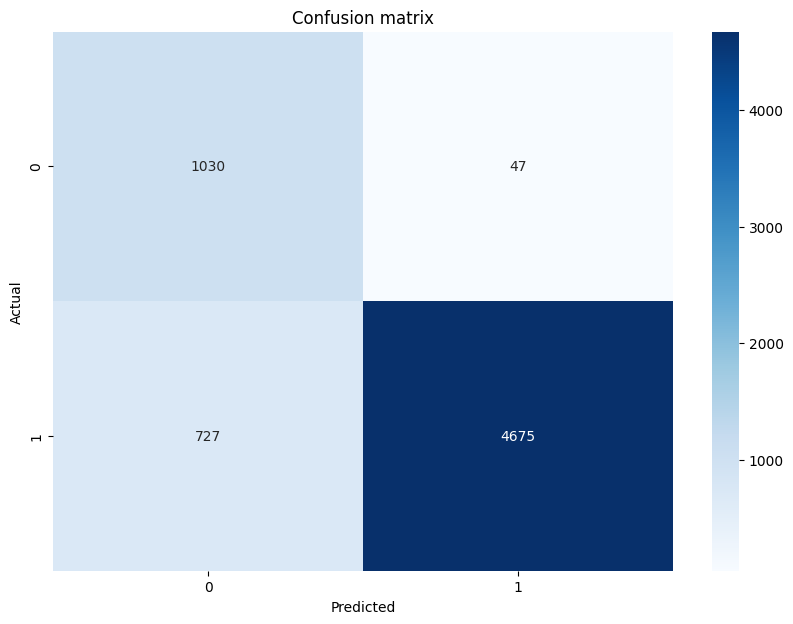

Test Loss: 0.7080318331718445
Test Accuracy: 0.8805370926856995


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns

# Extract sentences and labels from the new dataframe
sentences_test = merged['lyrics_sentences'].values
labels_test = merged['smell_event'].values

# Filter out any sentences that are NaN from both sentences and labels
valid_indexes = pd.notnull(sentences_test)
sentences_test = sentences_test[valid_indexes]
labels_test = labels_test[valid_indexes]

# Tokenize the sentences
input_ids_test = [tokenizer.encode(sent, add_special_tokens=True, max_length=MAX_LEN, padding='max_length', truncation=True) for sent in sentences_test]

# Convert lists to numpy arrays
input_ids_test = np.array(input_ids_test)
labels_test = np.array(labels_test)

# Convert arrays to tensors
test_inputs = tf.constant(input_ids_test)
test_labels = tf.constant(labels_test)

# Evaluate the model on the test data
test_loss, test_acc = model.evaluate(test_inputs, test_labels, verbose=1)

# Predict the labels for the test set
predictions = model.predict(test_inputs)[0]  # Access the predictions
predicted_labels = np.argmax(predictions, axis=1)

# Print a classification report
print(classification_report(test_labels, predicted_labels))

# Calculate additional evaluation metrics
f1 = f1_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
auroc = roc_auc_score(test_labels, predictions[:, 1])  # Assuming binary classification, use the probabilities of the positive class

# Print the additional metrics
print("F1-Score:", f1)
print("Precision:", precision)
print("Recall:", recall)
print("AUROC:", auroc)

# Print the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_acc}")
